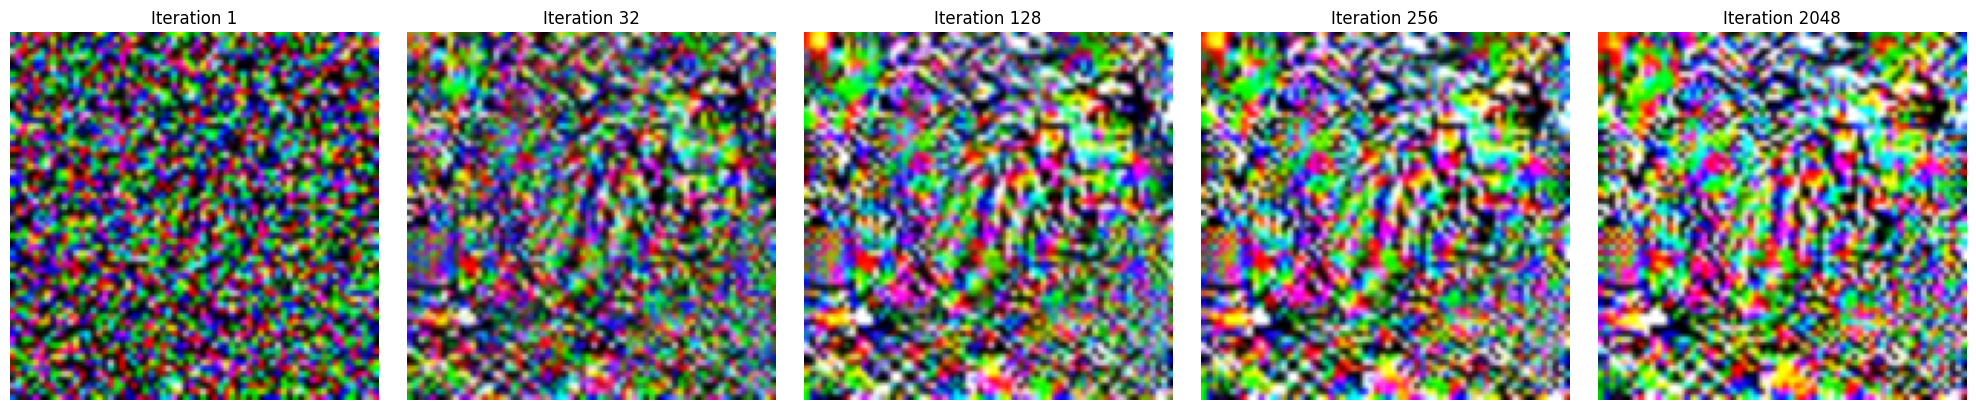

In [24]:
import torch
import torchvision.models as models
from torchvision.transforms.functional import resize
import matplotlib.pyplot as plt

# Load pre-trained Inception v1 (GoogLeNet in PyTorch)
model = models.googlenet(pretrained=True).eval()
model.to('mps')

# Set up the layer we want to visualize
# In this case, we'll use the equivalent of "mixed4a_pre_relu:453" in InceptionV1
# This corresponds to the 4th Inception module, b branch, before ReLU
target_layer = model.inception4a
target_channel = 452

# Parameters
image_size = 64
learning_rate = 0.05
num_iterations = 2048
thresholds = [1, 32, 128, 256, 2048]

# Create a parameter to optimize
# 1 -- batch size
# 3 -- channels (colour)
# image_size -- actual width (and height)
# require_grad -- change values generated by randn
image = torch.randn(1, 3, image_size, image_size, requires_grad=True, device='mps')

# Optimizer
optimizer = torch.optim.Adam([image], lr=learning_rate)

# Hook to get intermediate layer output
# activation dict in this implementation will always have a single kv pair (target: activation)
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

# register a hook to be able to fetch activations of this particular layer/channel later
target_layer.register_forward_hook(get_activation('target'))

# function where we perform forward pass, extract average activation (as a single number) and return negation of it
# negation because we have to _maximize_ the objective and _minimize_ the loss
#   so if loss will go from 15 to 7 (lowering), objective will go from -15 to -7 (growing)
def visualize():
    model(image)
    loss = -activation['target'][0, target_channel].mean()
    loss.backward()
    return loss.item()

# Render function
def render_vis(thresholds):
    images = []
    for i in range(num_iterations):
        optimizer.zero_grad()
        loss = visualize()
        optimizer.step()
        
        # Clamp values to [0, 1]
        with torch.no_grad():
            image.clamp_(0, 1)
        
        if i + 1 in thresholds:
            img_np = (image
                      .squeeze() # remove batch dimension
                      .detach() # detach from graph (will not be included in autograd and never require the gradient) 
                      .cpu() # from mps/cuda -> cpu
                      .numpy() # to numpy array instead of pytorch.Tensor
                      )
            images.append(img_np)
    
    return images

# Run visualization
# imgs = render_vis(thresholds)

# create len(imgs) subplots (5 in this case)
fig, axs = plt.subplots(1, len(imgs), figsize=(20, 4))
for i, img in enumerate(imgs):
    # Resize image to double its size
    img_resized = resize(torch.from_numpy(img), [image_size*2, image_size*2])
    # in InceptionV1 the dimensions of the resulting image are (channels, height, width)
    # matplotlib expects (height, width, channels)
    img_resized = img_resized.permute(1, 2, 0).numpy()
    
    # display the image on a specific axis
    axs[i].imshow(img_resized)
    # disable x/y number grid
    axs[i].axis('off')
    axs[i].set_title(f'Iteration {thresholds[i]}')

plt.tight_layout() # makes arrangement of the images a bit nicer
plt.show()

### Target Layer
target_layer is one of the layers of Inception model

btw, in branch3 they have 3x3 convolution instead of 5x5 -- it's a <a href="https://github.com/pytorch/vision/issues/906">known bug</a> (:

In [6]:
target_layer

Inception(
  (branch1): BasicConv2d(
    (conv): Conv2d(480, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch2): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(480, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(96, 208, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(208, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (branch3): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(480, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): Batc